In [1]:
# fix k1, k2, beta1, beta2 at true optimal values, learn change of variables
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import pyvarinf
from torch.utils.data import TensorDataset
import numpy as np
import scipy.special as sc
from scipy import stats
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import copy


# Implementing Normalising Flow

In [2]:


class EvenTransform(nn.Module):
    def __init__(self, dim=2, use_relu=False):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, 1).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.use_relu = use_relu

    def forward(self, z):
        z1, z2 = z[:, :1], z[:, 1:]
        if self.use_relu:
            q = z2 + nn.ReLU()(torch.mm(z1, self.w.T) + self.b)
        else:
            q = z2 + nn.Tanh()(torch.mm(z1, self.w.T) + self.b)
        return torch.cat((z1, q), dim=1)

    def inverse(self, x):
        x1, x2 = x[:, :1], x[:, 1:]
        if self.use_relu:
            z2 = x2 - nn.ReLU()(torch.mm(x1, self.w.T) + self.b)
        else:
            z2 = x2 - nn.Tanh()(torch.mm(x1, self.w.T) + self.b)
        return torch.cat((x1, z2), dim=1)


class OddTransform(nn.Module):
    def __init__(self, dim=2, use_relu=False):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, 1).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.use_relu = use_relu

    def forward(self, z):
        z1, z2 = z[:, :1], z[:, 1:]
        if self.use_relu:
            p = z1 + nn.ReLU()(torch.mm(z2, self.w.T) + self.b)
        else:
            p = z1 + nn.Tanh()(torch.mm(z2, self.w.T) + self.b)
        return torch.cat((p, z2), dim=1)

    def inverse(self, x):
        x1, x2 = x[:, :1], x[:, 1:]
        if self.use_relu:
            z1 = x1 - nn.ReLU()(torch.mm(x2, self.w.T) + self.b)
        else:
            z1 = x1 - nn.Tanh()(torch.mm(x2, self.w.T) + self.b)
        return torch.cat((z1, x2), dim=1)


class AltFlow(nn.Module):
    def __init__(self, dim=2, K=6, use_relu=False):
        super().__init__()
        self.layers = []

        for k in range(K):
            if k % 2 == 0:
                self.layers.append(EvenTransform(dim, use_relu))
            else:
                self.layers.append(OddTransform(dim, use_relu))

        self.model = nn.Sequential(*self.layers)

    def forward(self, z):

        x = self.model(z)
        return x, 0

    def inverse(self, x):

        for layer in reversed(self.layers):
            z = layer.inverse(x)
            x = z

        return z


class RotShearTransform(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, 1).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.w2 = nn.Parameter(torch.randn(1, 1).normal_(0, 0.1))
        self.b2 = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(2*np.pi*torch.rand(1, 1))

    def forward(self, z):
        z1, z2 = z[:, :1], z[:, 1:]
        rot_mat = torch.stack([torch.cos(self.u),torch.sin(self.u),-torch.sin(self.u),torch.cos(self.u)]).reshape(2,2)
        temp = nn.LeakyReLU()(torch.mm(z1, self.w.T) + self.b)
        temp = nn.LeakyReLU()(torch.mm(temp, self.w2.T) + self.b2)

        q = z2 + temp
        return torch.mm(torch.cat((z1, q), dim=1), rot_mat)

    def inverse(self, x):
        rot_mat = torch.stack([torch.cos(self.u),torch.sin(self.u),-torch.sin(self.u),torch.cos(self.u)]).reshape(2,2)
        x = torch.mm(x,torch.inverse(rot_mat))
        x1, x2 = x[:, :1], x[:, 1:]
        temp = nn.LeakyReLU()(torch.mm(x1, self.w.T) + self.b)
        temp = nn.LeakyReLU()(torch.mm(temp, self.w2.T) + self.b2)
        z2 = x2 - temp
        return torch.cat((x1, z2), dim=1)


class rot_shear_Flow(nn.Module):
    def __init__(self, dim=2, K=6):
        super().__init__()
        self.layers = []

        for k in range(K):
            self.layers.append(RotShearTransform(dim))

        self.model = nn.Sequential(*self.layers)

    def forward(self, z):

        x = self.model(z)
        return x, 0

    def inverse(self, x):

        for layer in reversed(self.layers):
            z = layer.inverse(x)
            x = z

        return z


class PlanarTransform(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))

    def forward(self, z):
        if torch.mm(self.u, self.w.T) < -1:
            self.u.data = self.u_hat()
        zk = z + self.u * nn.Tanh()(torch.mm(z, self.w.T) + self.b)
        return zk

    def inverse(self, x):
        return x - self.u * nn.Tanh()(torch.mm(x, self.w.T) + self.b)

    def u_hat(self):
        # enforce w^T u > -1 to ensure invertibility
        # slows down the computation quite a bit, should always try to run without first
        wtu = torch.mm(self.u, self.w.T)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        return (
            self.u + (m_wtu - wtu) * self.w / torch.norm(self.w, p=2, dim=1) ** 2
        )  # torch.mul(self.w,self.w).sum()

    def log_det_J(self, z):
        if torch.mm(self.u, self.w.T) < -1:
            # print("Normalising u to u_hat. Old w.T.dot(u)=", torch.mm(self.u, self.w.T))
            self.u.data = self.u_hat()
            # print("New w.T.dot(u):", torch.mm(self.u, self.w.T))

        a = torch.mm(z, self.w.T) + self.b
        psi = (1 - nn.Tanh()(a) ** 2) * self.w
        abs_det = (1 + torch.mm(self.u, psi.T)).abs()
        log_det = torch.log(1e-4 + abs_det)
        # debugging
        if torch.isnan(log_det).sum() > 0:
            print("u:", self.u)
            print("w:", self.w)
            print("abs_det:", abs_det)
        return log_det


class PlanarFlow(nn.Module):
    def __init__(self, dim=2, K=6):
        super().__init__()
        self.layers = []

        for _ in range(K):
            self.layers.append(PlanarTransform(dim))

        self.model = nn.Sequential(*self.layers)

    def forward(self, z):
        log_det_J = 0

        for layer in self.layers:
            log_det_J += layer.log_det_J(z)
            z = layer(z)

        return z, log_det_J


class FCNN(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim,bias=False),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim,bias=False),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim,bias=False),
        )

    def forward(self, x):
        return self.network(x)



class RealNVP(nn.Module):
    """
    Non-volume preserving flow.
    [Dinh et. al. 2017]
    """
    def __init__(self, dim, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.t1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.t2 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s2 = base_network(dim // 2, dim // 2, hidden_dim)

    def forward(self, x):
        lower, upper = x[:,:self.dim // 2], x[:,self.dim // 2:]
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = t1_transformed + upper * torch.exp(s1_transformed)
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = t2_transformed + lower * torch.exp(s2_transformed)
        z = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(s1_transformed, dim=1) + \
                  torch.sum(s2_transformed, dim=1)
        return z, log_det

    def inverse(self, z):
        lower, upper = z[:,:self.dim // 2], z[:,self.dim // 2:]
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = (lower - t2_transformed) * torch.exp(-s2_transformed)
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = (upper - t1_transformed) * torch.exp(-s1_transformed)
        x = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(-s1_transformed, dim=1) + \
                  torch.sum(-s2_transformed, dim=1)
        return x, log_det



# Running experiment

In [3]:

def create_data(sample_size):

    x = torch.rand(2*sample_size,1)
    # generate y as N(theta_1*tanh(theta_2 x), 1) by setting theta_1=theta_2=0
    y = torch.randn(2*sample_size,1)
    # put x, y into trainloader
    params = {'batch_size': 32,
              'shuffle': True}
    # TODO: not using validation or testing set for anythning at the moment
    train_size = sample_size
    valid_size = int(sample_size * 0.5)
    test_size = 2 * sample_size - train_size - valid_size
    dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(TensorDataset(x, y), [train_size, valid_size, test_size])
    train_loader = torch.utils.data.DataLoader(dataset_train, **params)
    # TODO: sample size has to be a multiple of 32 at the moment
    valid_loader = torch.utils.data.DataLoader(dataset_valid, **params)
    test_loader = torch.utils.data.DataLoader(dataset_test, **params)

    return train_loader


# n S_n = \sum_{i=1}^n -\log p(y_i | x_i, \theta_0)
def empirical_entropy_sum(train_loader):

    entropy = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        y_rv = Normal(0, 1)
        entropy += y_rv.log_prob(target).sum()

    return -entropy


# \int_0^x u^h \exp(-\beta u^{2k}) \,du = \frac{\beta^{-\lambda}\Gamma(\lambda)\gamma(\lambda,\beta x^{2k})}{2k}
def almost_gammainc(beta, h, k, upper):

    if k == 0:
        print('warning: k=0 not allowed in almost_gammainc')
    if beta == 0:
        return (upper**(h+1))/(h+1)
    else:
        lmbda = torch.Tensor([(h+1)/(2*k)])
        if upper <= 0:
            print('Warning: upper must be strictly positive')
        Gamma = torch.exp(torch.lgamma(lmbda))
        return beta**(-lmbda)/(2*k)*Gamma*torch.igamma(lmbda,beta*(upper**(2*k)))


# calculate entropy of univariate q where q \propto exp(-beta u^{2k}) 1(u \in [0,upper])
def entropy_individual_q(beta, k, upper):

    if k == 0:
        entropy = -torch.log(upper)
    else:
        B = almost_gammainc(beta, 0, k, upper)
        intgrl = almost_gammainc(beta, 2 * k, k, upper) / B
        entropy = -beta * intgrl - torch.log(B)

    return entropy


# analytic E_q log q = E_q1 \log q1 + E_q2 \log q2
def elbo_prior(kbeta, xi_integration_lims):

    # unpack tuples
    xi1_upper, xi2_upper = xi_integration_lims
    k1, k2, beta1, beta2 = kbeta

    if (k1 == 0) and (k2 == 0):
        print('Warning: at least one entry in multi-index k must be nonzero')

    prior_loss = entropy_individual_q(beta1, k1, xi1_upper) + \
                 entropy_individual_q(beta2, k2, xi2_upper)

    return prior_loss


# \log q where q \propto \exp(-beta u^2k) 1(u \in (0,upper))
def log_q(xi, beta, k, upper):
    if k == 0:
        return 0
    else:
        B = almost_gammainc(beta, 0, k, upper)
        return -beta*xi**(2*k) - torch.log(B)


# TF^{-1}(\epsilon)
def inv_cdf_trunc_gnorm(epsilon, b, k, beta):
    lmbda = 1/(2*k)
    u = epsilon*gnorm_cdf(b,k,beta)-1/2
    v = torch.exp(torch.lgamma(lmbda))
    return u*v/(beta**lmbda)/k


# if k=0, q(\xi) is uniform [0, upper]
# otherwise, we need to sample from a truncated [0, upper] generallized normal distribution.
def get_individual_xi_sample(k, beta, upper, R):

    if k == 0:
        # print('uniform [{}, {}]'.format(0,upper))
        xis = upper*torch.FloatTensor(R,1).uniform_(0, 1)
    else:
        # print('truncated gennorm [{}, {}]'.format(0,upper))
        epsilon = torch.FloatTensor(R,1).uniform_(0, 1)
        xis = inv_cdf_trunc_gnorm(epsilon, upper, k, beta)

    return xis


# \sum_{i=1}^n \log p(y_i |x_i, g(\xi)) where g(\xi)=\theta
def loglik(theta1, theta2, train_loader):

    logprob = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        x = data.matmul(theta1.reshape([1,1]))
        x = torch.tanh(x)
        x = x.matmul(theta2.reshape([1,1]))
        y_rv = Normal(x, 1)
        logprob += y_rv.log_prob(target).sum()

    return logprob


# given $R$ samples of (theta_1,theta_2), the empirical average of
# E_q \sum_{i=1}^n \log p(y_i|x_i,theta)
def elbo_loglik(theta, train_loader):

    R = theta.shape[0]
    elbo_loglik = 0.0
    for r in range(R):
        theta1 = theta[r,0]
        theta2 = theta[r,1]
        elbo_loglik += loglik(theta1, theta2, train_loader)

    return elbo_loglik / R


# cdf of generalized normal distribution with scale = beta^-1/2k and shape = 2k
def gnorm_cdf(x, k, beta):
    g = torch.exp(torch.lgamma(1/(2*k)))
    return (1+torch.igamma(1/(2*k), x/beta)/g)/2


# currently implements map g(\xi) = \theta given ansatz q with "true" k_1, k_2, beta_1, beta_2
def train(resolution_network, train_loader, kbeta, R):

    k1, k2, beta1, beta2 = kbeta

    lr = 1e-3
    optimizer = torch.optim.Adam(resolution_network.parameters(), lr=lr)

    # kbetas = [(1, 0, sample_size, 1), (0, 1, 1, sample_size)]

    for epoch in range(1, 100):

        optimizer.zero_grad()

        xi_upper, _ = resolution_network(torch.Tensor([[1,1]])) # g inverse
        # TODO: how to ensure xi1_upper and xi2_upper are strictly positive?
        xi1_upper = xi_upper[0, 0]
        xi2_upper = xi_upper[0, 1]
        xi_integration_lims = xi1_upper, xi2_upper

        xi1s = get_individual_xi_sample(k1, beta1, xi1_upper, R)
        xi2s = get_individual_xi_sample(k2, beta2, xi2_upper, R)
        xi = torch.cat((xi1s, xi2s), dim=1)
        theta, log_jacobians = resolution_network.inverse(xi.float()) # g

        loglik_elbo = elbo_loglik(theta, train_loader)
        prior_elbo = elbo_prior(kbeta, xi_integration_lims)
        elbo = loglik_elbo + log_jacobians.mean() - prior_elbo

        # individual_elbos[counter] = elbo
        # counter += 1

        # loss = torch.min(-individual_elbos)
        loss = -elbo
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'epoch {epoch}: loss {loss.item()}')

    return resolution_network


def evaluate(resolution_network, train_loader, kbeta, R):

    k1, k2, beta1, beta2 = kbeta

    resolution_network.eval()

    xi_upper, _ = resolution_network(torch.Tensor([[1, 1]]))
    # TODO: how to ensure xi1_upper and xi2_upper are strictly positive?
    xi1_upper = xi_upper[0, 0]
    xi2_upper = xi_upper[0, 1]
    xi_integration_lims = xi1_upper, xi2_upper

    xi1s = get_individual_xi_sample(k1, beta1, xi1_upper, R)
    xi2s = get_individual_xi_sample(k2, beta2, xi2_upper, R)
    xi = torch.cat((xi1s, xi2s), dim=1)

    with torch.no_grad():
        theta, log_jacobians = resolution_network.inverse(xi.float())
        loglik_elbo = elbo_loglik(theta, train_loader)
        prior_elbo = elbo_prior(kbeta, xi_integration_lims)
        elbo = loglik_elbo + log_jacobians.mean() - prior_elbo

    return elbo



In [4]:
%%time 
resolution_network = RealNVP(dim=2,hidden_dim=2)

ns = [int(round(np.exp(4)))*32, int(round(np.exp(5)))*32, int(round(np.exp(6)))*32, int(round(np.exp(7)))*32]
metric = []
R = 100
for sample_size in ns:
    # resolution_network = RealNVP(base_dist="gaussian", nf_couplingpair=2, nf_hidden=2, w_dim=2, sample_size=sample_size)

    kbeta = (torch.Tensor([1]), torch.Tensor([1]), torch.Tensor([np.sqrt(sample_size)]), torch.Tensor([np.sqrt(sample_size)]))

    train_loader = create_data(sample_size)
    nSn = empirical_entropy_sum(train_loader).item()

    resolution_net = copy.deepcopy(resolution_network)

    resolution_net = train(resolution_net, train_loader, kbeta, R)
    elbo = evaluate(resolution_net, train_loader, kbeta, R).item()

    metric += [elbo + nSn]
    print(f'achieved elbo plus entropy {elbo+nSn:.2f} for sample size n {sample_size}')



epoch 10: loss 2528.433837890625
epoch 20: loss 2528.434814453125
epoch 30: loss 2528.4306640625
epoch 40: loss 2528.427490234375
epoch 50: loss 2528.414794921875
epoch 60: loss 2528.3984375
epoch 70: loss 2528.3955078125
epoch 80: loss 2528.406494140625
epoch 90: loss 2528.3759765625
achieved elbo plus entropy -2.89 for sample size n 1760
epoch 10: loss 6704.92236328125
epoch 20: loss 6704.91943359375
epoch 30: loss 6704.92138671875
epoch 40: loss 6704.91259765625
epoch 50: loss 6704.89697265625
epoch 60: loss 6704.89453125
epoch 70: loss 6704.8857421875
epoch 80: loss 6704.90087890625
epoch 90: loss 6704.888671875
achieved elbo plus entropy -3.52 for sample size n 4736
epoch 10: loss 18320.310546875
epoch 20: loss 18320.3125
epoch 30: loss 18320.294921875
epoch 40: loss 18320.296875
epoch 50: loss 18320.291015625
epoch 60: loss 18320.2890625
epoch 70: loss 18320.2890625
epoch 80: loss 18320.2890625
epoch 90: loss 18320.283203125
achieved elbo plus entropy -3.92 for sample size n 1289

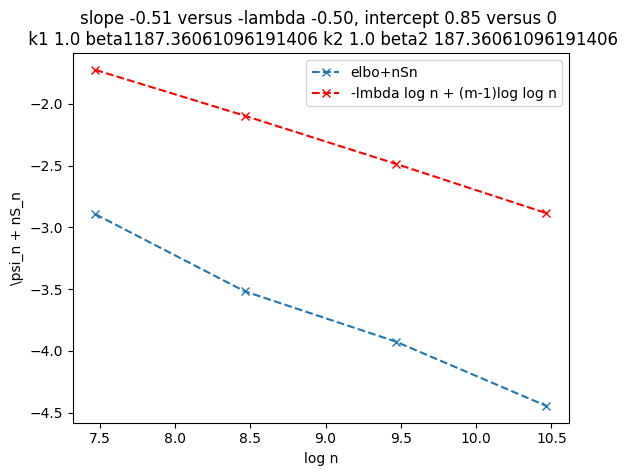

In [6]:
k1, k2, beta1, beta2 = kbeta

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(ns), metric)
plt.plot(np.log(ns), metric, 'x--',label='elbo+nSn')
plt.plot(np.log(ns), -np.log(ns)/2 + np.log(np.log(ns)), 'rx--',label='-lmbda log n + (m-1)log log n')
plt.xlabel('log n')
plt.ylabel('\psi_n + nS_n')
plt.legend()
plt.title('slope {:.2f} versus -lambda {:.2f}, intercept {:.2f} versus 0 \n k1 {} beta1{} k2 {} beta2 {}'
            .format(slope,-1/2, intercept,k1.numpy().item(),beta1.numpy().item(),k2.numpy().item(),beta2.numpy().item()))
plt.show()